# The Milwaukee Journal Sentinel and Pothole fill times

Two pieces from Milwaukee Journal-Sentinel ([first](http://archive.jsonline.com/news/milwaukee/32580074.html), [second](https://web.archive.org/web/20081223094123/http://www.jsonline.com/news/milwaukee/32580034.html)) outline racial disparities in pothole fill times. Using a combintion of geospatial analysis, census data, and linear regression, we'll see what we can find.

<p class="reading-options">
  <a class="btn" href="/milwaukee-potholes/milwaukee-journal-sentinel-and-potholes-full-walkthrough">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/milwaukee-potholes/notebooks/Milwaukee Journal Sentinel and potholes full walkthrough.ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/milwaukee-potholes/notebooks/Milwaukee Journal Sentinel and potholes full walkthrough.ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **2007-2010 POTHOLES.xls:** 2007-2010 pothole data - 2007-2010 combined pothole data
* **2010-2013 POTHOLES.xls:** 2010-2013 pothole data - 2010-2013 pothole data
* **2013-2017 POTHOLES.xls:** 2013-2017 pothole data - 2013-2017 pothole data
* **tl_2013_55_tract.zip:** census tract shapefile - census tracts including Milwaukee for spatial joining
* **addresses_geocoded.csv:** geocoded addresses - geocoded pothole addresses
* **R12216226_SL140.csv:** median income census data - American Community Survey table A14006
* **R12216099_SL140.csv:** racial makeup census data - American Community Survey table A04001


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/2007-2010 POTHOLES.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/2010-2013 POTHOLES.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/2013-2017 POTHOLES.xls -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/tl_2013_55_tract.zip -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/addresses_geocoded.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/R12216226_SL140.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/milwaukee-potholes/data/R12216099_SL140.csv -P data

## Imports

We're importing pandas, as well as setting it to display up to 200 columns at a time.

In [3]:
import pandas as pd

pd.set_option("display.max_columns", 200)

%matplotlib inline

## Importing our data

The city delivered multiple files to us, so we'll need to filter them down to **just 2013.** What seems straightforward might actually be an editorial decision: when we say "a pothole from 2013," what exactly do we mean? Filed in 2013? Filled in 2013? Filed and filled?

We're going to consider a pothole as being from 2013 if it was entered in 2013.

In [4]:
potholes_2010 = pd.read_excel("data/2010-2013 POTHOLES.xls")
potholes_2013 = pd.read_excel("data/2013-2017 POTHOLES.xls")
potholes = pd.concat([potholes_2010, potholes_2013])
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt
0,3839,N 10TH ST,2013-07-15 23:35,2013-07-16 05:46,2013-07-17 05:50
1,4900,W MELVINA ST,2013-07-15 20:05,2013-07-16 05:46,2013-07-24 16:58
2,2400,W WISCONSIN AV,2013-07-15 20:00,2013-07-16 05:56,2013-07-25 14:42
3,1800,W HAMPTON AV,2013-07-15 19:55,2013-07-16 05:46,2013-07-18 06:06
4,4718,N 19TH ST,2013-07-15 19:50,2013-07-16 05:46,2013-08-02 06:08


How many do we have?

In [7]:
potholes = potholes[potholes.EnterDt.str.startswith('2013')]
potholes.shape

(12836, 5)

### Double-checking our dates

Let's confirm that our date range is what we expected. We'll also need to mind **missing data** - if a pothole was never filled, it will be missing a `ResolvDt`.

In [8]:
potholes.EnterDt.dropna().agg(['min', 'max'])

min    2013-01-02 06:31
max    2013-12-31 17:06
Name: EnterDt, dtype: object

In [9]:
potholes.ResolvDt.dropna().agg(['min', 'max'])

min    2013-01-02 06:33
max    2014-01-23 17:05
Name: ResolvDt, dtype: object

## Feature engineering: fill time

Let's calculate how long it took to fill potholes in 2013. We'll save this into a new column.

In [10]:
# We'll need to convert our columns into datetimes to find the difference

potholes['EnterDt'] = pd.to_datetime(potholes.EnterDt)
potholes['ResolvDt'] = pd.to_datetime(potholes.ResolvDt)
potholes['difference'] = potholes.ResolvDt - potholes.EnterDt
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt,difference
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56,2013-07-25 14:42:00,9 days 18:42:00
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46,2013-07-18 06:06:00,2 days 10:11:00
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46,2013-08-02 06:08:00,17 days 10:18:00


What kind of datatype is `17 days 10:18:00`?

In [11]:
potholes.difference.dtype

dtype('<m8[ns]')

Hm, we probably need to **turn that into an integer.** Otherwise we won't be able to do regression on it!

In [12]:
potholes['wait_days'] = potholes['difference'].dt.components['days'] + \
                        potholes['difference'].dt.components['hours'] / 24
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00,1.250000
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00,8.833333
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56,2013-07-25 14:42:00,9 days 18:42:00,9.750000
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46,2013-07-18 06:06:00,2 days 10:11:00,2.416667
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46,2013-08-02 06:08:00,17 days 10:18:00,17.416667


## Census data

Data from the US Government is often Latin-1 encoded instead of UTF-8, so we'll need to specify the encoding. We also want to demand that `Geo_FIPS` be read in as a string so as to not lose leading zeroes.

In [14]:
census = pd.read_csv("data/R12216099_SL140.csv", encoding='latin-1', dtype={'Geo_FIPS': 'str'})
census.head(2)

,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATECE,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_PLACESE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITSCE,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_UACP,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_VTD,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A04001_001,SE_A04001_002,SE_A04001_003,SE_A04001_004,SE_A04001_005,SE_A04001_006,SE_A04001_007,SE_A04001_008,SE_A04001_009,SE_A04001_010,SE_A04001_011,SE_A04001_012,SE_A04001_013,SE_A04001_014,SE_A04001_015,SE_A04001_016,SE_A04001_017
0,55079000101,14000US55079000101,"Census Tract 1.01, Milwaukee County, Wisconsin","Census Tract 1.01, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4717,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5306,5015,1343,3567,13,70,0,16,6,291,37,0,0,0,0,254,0
1,55079000102,14000US55079000102,"Census Tract 1.02, Milwaukee County, Wisconsin","Census Tract 1.02, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4718,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3648,3549,1034,2195,36,118,0,0,166,99,67,32,0,0,0,0,0


### Feature engineering: Race

Let's use this dataset to create a *second* dataframe of all of our features. Each row should contain:

* The census tract number
* The percent of the population that is White
* The percent of the population that is Black
* The percent of the population that is Hispanic
* The percent of the population that is a minority (non-White)

We'll need to read the **data dictionary** to know exactly what the columns mean.

In [15]:
census['pct_white'] = census.SE_A04001_003 / census.SE_A04001_001 * 100
census['pct_black'] = census.SE_A04001_004 / census.SE_A04001_001 * 100
census['pct_hispanic'] = census.SE_A04001_010 / census.SE_A04001_001 * 100
census['pct_minority'] = 100 - census.pct_white
census = census[['Geo_FIPS', 'pct_white', 'pct_black', 'pct_hispanic', 'pct_minority']]
census.head()

,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority
0,55079000101,25.310969,67.225782,5.484357,74.689031
1,55079000102,28.344298,60.169956,2.713816,71.655702
2,55079000201,24.733876,55.458151,16.113546,75.266124
3,55079000202,42.488931,44.433903,2.783049,57.511069
4,55079000301,75.056012,16.430172,0.000000,24.943988


## Combine datasets

We need to create a new dataframe by merging our street addresses with our census data. It would be nice to merge on census tract code...

In [16]:
potholes.head(2)

,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00,1.250000
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00,8.833333


...but our addresses data does **not** have a census tract on them!

### Connecting addresses to census tracts

To make this work, we need to go through a **multi-step process**. First we need to find the lat/lon coordinates for each address, then we need to find out which census tract it's in.

To start with, I made a list of unique addresses and save them to a file. I then **geocoded** this file, converting the addresses to latitude and longitude. You can use something like [Little Geocoder](http://littlecolumns.com/tools/little-geocoder/), [geocodio](https://www.geocod.io/), or the Google Maps API to perform the conversion.

Finally, I opened these latitude/longitude pairs in [QGIS](https://qgis.org/). The QGIS command **Join attributes by location** will merge datasets that geographically overlap each other. If you have one layer that's a list of lat/lon points and one layer that's a shapefile with census tract information, **join attributes by location** can create a new layer of lat/lon points that also has census tract information. By downloading a shapefile of census tracts from the Census Bureau, I was able to combine these two datasets.

Finally, I exported the result by right clicking the layer, selecting **Export As**, and making sure the output is another CSV.

### Merging

We now have three datasets:

* Addresses and pothole fill times
* Census data according with census tract codes
* Addresses with census tract codes

We'll need to merge them each together to create one whole dataset.

In [17]:
addresses_tracts = pd.read_csv("addresses_with_tract.csv", dtype={'GEOID': 'str'})
addresses_tracts.head()

,address,GEOID
0,8900 N 124TH ST,55133200202
1,2200 N TERRACE AV,55079186900
2,1000 N PROSPECT AV,55079186900
3,1700 N PROSPECT AV,55079186900
4,2298 N TERRACE AV,55079186900


In [18]:
merged = addresses_tracts.merge(census, left_on='GEOID', right_on='Geo_FIPS')
merged.head()

,address,GEOID,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority
0,2200 N TERRACE AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943
1,1000 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943
2,1700 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943
3,2298 N TERRACE AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943
4,1400 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943


In [19]:
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00,1.250000
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00,8.833333
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56,2013-07-25 14:42:00,9 days 18:42:00,9.750000
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46,2013-07-18 06:06:00,2 days 10:11:00,2.416667
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46,2013-08-02 06:08:00,17 days 10:18:00,17.416667


In [20]:
potholes['address'] = potholes.A.astype(str) + ' ' + potholes.Street
potholes.head()

,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days,address
0,3839,N 10TH ST,2013-07-15 23:35:00,2013-07-16 05:46,2013-07-17 05:50:00,1 days 06:15:00,1.250000,3839 N 10TH ST
1,4900,W MELVINA ST,2013-07-15 20:05:00,2013-07-16 05:46,2013-07-24 16:58:00,8 days 20:53:00,8.833333,4900 W MELVINA ST
2,2400,W WISCONSIN AV,2013-07-15 20:00:00,2013-07-16 05:56,2013-07-25 14:42:00,9 days 18:42:00,9.750000,2400 W WISCONSIN AV
3,1800,W HAMPTON AV,2013-07-15 19:55:00,2013-07-16 05:46,2013-07-18 06:06:00,2 days 10:11:00,2.416667,1800 W HAMPTON AV
4,4718,N 19TH ST,2013-07-15 19:50:00,2013-07-16 05:46,2013-08-02 06:08:00,17 days 10:18:00,17.416667,4718 N 19TH ST


In [21]:
merged = merged.merge(potholes, on='address')
merged.head()

,address,GEOID,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days
0,1400 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333
1,1228 E JUNEAU AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000
2,1346 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000
3,1346 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667
4,1230 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000


## Missing data

Linear regression doesn't (always) deal well with missing data, so we'll remove any datasets that are missing any of our fields.

In [22]:
merged.shape

(12820, 14)

In [23]:
merged = merged.dropna()
merged.shape

(11856, 14)

As a result we removed 964 points from our dataset, about 7.5%.

## Linear regression

Using the `statsmodels` package, we'll run a linear regression to find the coefficient relating percent minority and pothole fill times.

In [28]:
import statsmodels.formula.api as smf

model = smf.ols("wait_days ~ pct_minority", data=merged)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_days   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     98.92
Date:                Tue, 14 Jan 2020   Prob (F-statistic):           3.24e-23
Time:                        14:07:40   Log-Likelihood:                -46657.
No. Observations:               11856   AIC:                         9.332e+04
Df Residuals:                   11854   BIC:                         9.333e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        6.7985      0.264     25.715      0.000       6.280       7.317
pct_minority     0.0373      0.004      9.946      0.000       0.030       0.045
==============================================================================
Omnibus:                     5674.093   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30528.208
Skew:                           2.318   Prob(JB):                         0.00
Kurtosis:                       9.348   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Translate that into the form **"every X percentage point change in the minority population translates to a Y change in pot hole fill times"**

In [18]:
# Every +1 percent point change in the minority population translates to a 0.04 day change in pot hole fill times

Do you feel comfortable that someone can understand that? Can you reword it to make it more easily understandable?

In [19]:
# times 25
# Every 25 percent point change in the minority population translates to a 1 day change in pot hole fill times

## Other methods of explanation

While the regression is *technically* correct, it just does't *sound* very nice, which makes it hard to communicate. 

What other options do we have?

### Averages

What's the average wait to fill a pothole between majority-white and majority-minority census tracts? We can create a new column to specify whether the census tract is majority white or not.

In [29]:
merged['majority_white'] = (merged.pct_white > 50).astype(int)
merged.groupby('majority_white').wait_days.describe()

,count,mean,std,min,25%,50%,75%,max
majority_white,,,,,,,,
0,7879.0,9.978281,13.050119,0.0,1.500000,4.875,13.000000,95.208333
1,3977.0,7.575067,10.945687,0.0,1.166667,3.125,8.708333,91.750000


This is how the following sentence in [the first story](http://archive.jsonline.com/news/milwaukee/32580074.html) came to be:

> potholes in mostly minority census tracts took an average of 11 days to repair, while potholes in mostly white census tracts took seven days.

That's much easier to understand than any regression output!

## Binning our data

Our initial regerssion answered the question **how does the average wait time to fill a pothole change as more minorities live in an area?**, but outliers and odd distributions can always cause problems with regression. Instead of trying to rely on each small increase in minority population to have the same effect, we could also **separate our data into different bins**.

In [30]:
# Bins between 0-100, with steps of 20
# of 0-10, 10-20, 20-30, ... 90-100
bins = range(0, 101, 20)

# Cut pct_minority into separate bins
merged['bin'] = pd.cut(merged.pct_minority, bins=bins)
merged.head()

,address,GEOID,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days,majority_white,bin
0,1400 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,1,"(20, 40]"
1,1228 E JUNEAU AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,1,"(20, 40]"
2,1346 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1346,N PROSPECT AV,2013-03-12 21:00:00,2013-03-13 06:13,2013-03-15 15:38:00,2 days 18:38:00,2.750000,1,"(20, 40]"
3,1346 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1346,N PROSPECT AV,2013-12-27 09:10:00,2013-12-30 06:00,2013-12-30 13:38:00,3 days 04:28:00,3.166667,1,"(20, 40]"
4,1230 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1230,N PROSPECT AV,2013-11-25 22:45:00,2013-11-26 06:18,2013-11-26 14:40:00,0 days 15:55:00,0.625000,1,"(20, 40]"


What's the distribution look like?

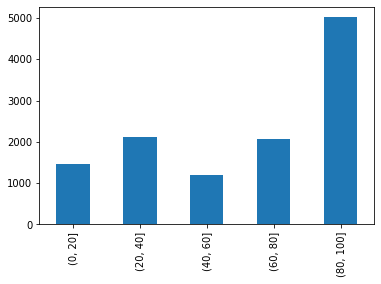

In [36]:
merged.bin.value_counts().sort_index().plot(kind='bar')

With the majority/minority white version, we split our data into **two bins.** Now instead we've split it into **five different bins**. We can do the same analysis we did before with grouping and describing.

In [37]:
merged.groupby('bin').wait_days.describe()

,count,mean,std,min,25%,50%,75%,max
bin,,,,,,,,
"(0, 20]",1456.0,6.742588,9.743595,0.0,1.125000,2.958333,7.250000,64.750000
"(20, 40]",2113.0,7.743157,11.231985,0.0,1.166667,3.166667,9.083333,91.750000
"(40, 60]",1201.0,9.350853,12.444021,0.0,1.250000,4.000000,11.958333,84.750000
"(60, 80]",2072.0,10.094494,12.883166,0.0,1.541667,4.979167,13.177083,95.208333
"(80, 100]",5014.0,10.055893,13.253221,0.0,1.552083,4.895833,13.041667,93.833333


How does the median change as the percentage of minority population increases?

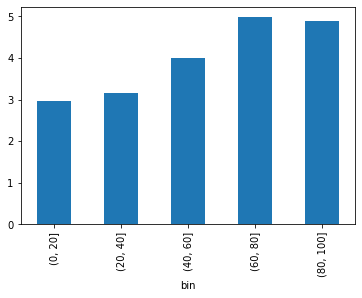

In [38]:
merged.groupby('bin').wait_days.median().plot(kind='bar')

## Adding income to our regression

`R12216226_SL140.csv` contains income data for each census tract in Wisconsin. Let's add it into our analysis to take into account differences in income.

In [43]:
income = pd.read_csv("data/R12216226_SL140.csv", encoding='latin-1', dtype={'Geo_FIPS': 'str'})
income.head(2)

,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,Geo_REGION,Geo_DIVISION,Geo_STATECE,Geo_STATE,Geo_COUNTY,Geo_COUSUB,Geo_PLACE,Geo_PLACESE,Geo_TRACT,Geo_BLKGRP,Geo_CONCIT,Geo_AIANHH,Geo_AIANHHFP,Geo_AIHHTLI,Geo_AITSCE,Geo_AITS,Geo_ANRC,Geo_CBSA,Geo_CSA,Geo_METDIV,Geo_MACC,Geo_MEMI,Geo_NECTA,Geo_CNECTA,Geo_NECTADIV,Geo_UA,Geo_UACP,Geo_CDCURR,Geo_SLDU,Geo_SLDL,Geo_VTD,Geo_ZCTA3,Geo_ZCTA5,Geo_SUBMCD,Geo_SDELM,Geo_SDSEC,Geo_SDUNI,Geo_UR,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A14006_001
0,55079000101,14000US55079000101,"Census Tract 1.01, Milwaukee County, Wisconsin","Census Tract 1.01, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4717,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27421.0
1,55079000102,14000US55079000102,"Census Tract 1.02, Milwaukee County, Wisconsin","Census Tract 1.02, Milwaukee County, Wisconsin",wi,140,0,ACSSF,4718,NaN,NaN,NaN,NaN,55,79,NaN,NaN,NaN,102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40692.0


In [44]:
income = income[['Geo_FIPS', 'SE_A14006_001']]
income.head(2)

,Geo_FIPS,SE_A14006_001
0,55079000101,27421.0
1,55079000102,40692.0


Individual dollars will make our results difficult to read, so we'll convert it to **tens of thousands of dollars**.

In [46]:
income['income_10k'] = income.SE_A14006_001 / 10000
income.head(2)

,Geo_FIPS,SE_A14006_001,income_10k
0,55079000101,27421.0,2.7421
1,55079000102,40692.0,4.0692


In [42]:
merged = merged.merge(income, on='Geo_FIPS')
merged.head(2)

,address,GEOID,Geo_FIPS,pct_white,pct_black,pct_hispanic,pct_minority,A,Street,EnterDt,PrintDt,ResolvDt,difference,wait_days,majority_white,bin,SE_A14006_001,income_10k
0,1400 N PROSPECT AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1400,N PROSPECT AV,2013-11-11 12:55:00,2013-11-12 06:52,2013-11-12 15:22:00,1 days 02:27:00,1.083333,1,"(20, 40]",66875.0,6.6875
1,1228 E JUNEAU AV,55079186900,55079186900,74.735057,9.114031,5.341246,25.264943,1228,E JUNEAU AV,2013-10-04 11:31:00,2013-10-07 14:38,2013-10-09 06:09:00,4 days 18:38:00,4.750000,1,"(20, 40]",66875.0,6.6875


### Perform the regression

In [47]:
import statsmodels.formula.api as smf

model = smf.ols("wait_days ~ pct_minority + income_10k", data=merged)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_days   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     70.05
Date:                Tue, 14 Jan 2020   Prob (F-statistic):           5.69e-31
Time:                        14:16:45   Log-Likelihood:                -46637.
No. Observations:               11856   AIC:                         9.328e+04
Df Residuals:                   11853   BIC:                         9.330e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6729      0.697      3.833      0.000       1.306       4.040
pct_minority     0.0609      0.005     11.583      0.000       0.051       0.071
income_10k       0.6788      0.106      6.392      0.000       0.471       0.887
==============================================================================
Omnibus:                     5676.105   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30709.656
Skew:                           2.317   Prob(JB):                         0.00
Kurtosis:                       9.380   Cond. No.                         438.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

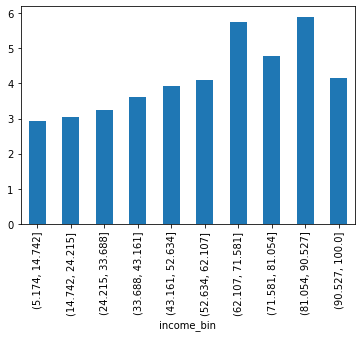

In [48]:
merged['income_bin'] = pd.cut(merged.pct_minority, bins=10)
merged.groupby('income_bin').wait_days.median().plot(kind='bar')

## Writing our results

After controlling for income, our coefficent for `pct_minority` was raised from 0.03 to 0.06. How do we put that into words?

> Every +1 percent point change in the minority population translates to a 0.06-day change in pot hole fill times

Which, if we multiply by 16, we can turn it into an actual day measurement:

> Every +16.6 percent point change in the minority population translates to a 1-day change in pot hole fill times

## Review

In this section we partially reproduced a **linear regression** from the Milwaukee Journal-Sentinel regarding **pothole fill times.** We discussed the different ways of communicating your findings to the reader, along with other options for analysis besides just regression on a field, such as **majority/minority splits** or **binning**.

## Discussion topics

What technique of communicating our findings was the most helpful to the reader? What was most useful to us as researchers?

In the published piece, it includes this phase: "the higher the minority population percentage in a census tract, the longer it took crews to fix potholes." How does that compare to the other approaches we've taken in this analysis?

The piece also states "The analysis could not account for the remaining factors: the age or size of roadways, citywide traffic counts or pothole severity, which the city considers as priorities." How do we feel about a regression that leaves out so many other variables? Is it still meaningful?

What kind of expert would you look for to double-check our analysis? Who did the Milwaukee Journal-Sentinel use?